# Лабораторная работа 1
## Задача предсказания оттока клиентов банка

## Выполнил: __Щеткин Дмитрий Сергеевич__

группа 2.1

### Импорт необходимых библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

### Обработка данных

In [2]:
df = pd.read_csv('data/churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df = pd.get_dummies(df, drop_first=True)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,True,False


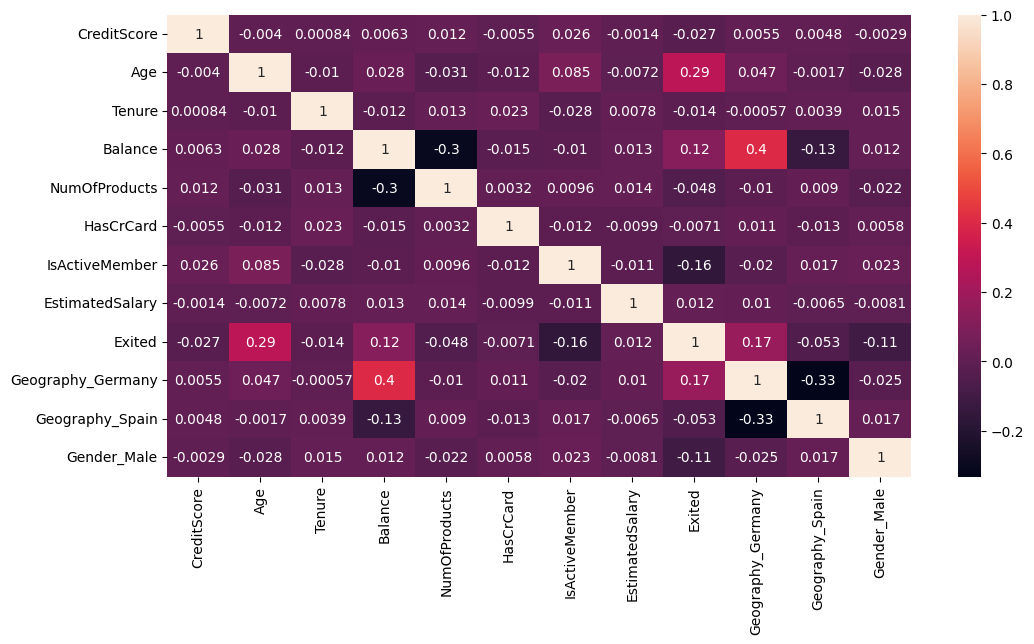

In [4]:
fig, ax = plt.subplots(figsize = (12, 6))
sns.heatmap(df.corr(), annot = True);

Наибольшая корреляция с целевой Exited:
- Age
- Balance
- IsActiveMember
- Geography_Germany
- Gender_Male

In [5]:
X = df[['Age', 'Balance','IsActiveMember', 'Geography_Germany', 'Gender_Male']]
y = df['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Обучение модели

In [7]:
model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    solver='liblinear',
    class_weight='balanced'
)
model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='liblinear')

In [8]:
y_train_pred = model.predict(X_train_scaled)
print(metrics.classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.90      0.71      0.79      6356
           1       0.38      0.70      0.49      1644

    accuracy                           0.71      8000
   macro avg       0.64      0.70      0.64      8000
weighted avg       0.79      0.71      0.73      8000



In [9]:
y_test_pred = model.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.92      0.72      0.81      1607
           1       0.39      0.73      0.51       393

    accuracy                           0.72      2000
   macro avg       0.65      0.72      0.66      2000
weighted avg       0.81      0.72      0.75      2000



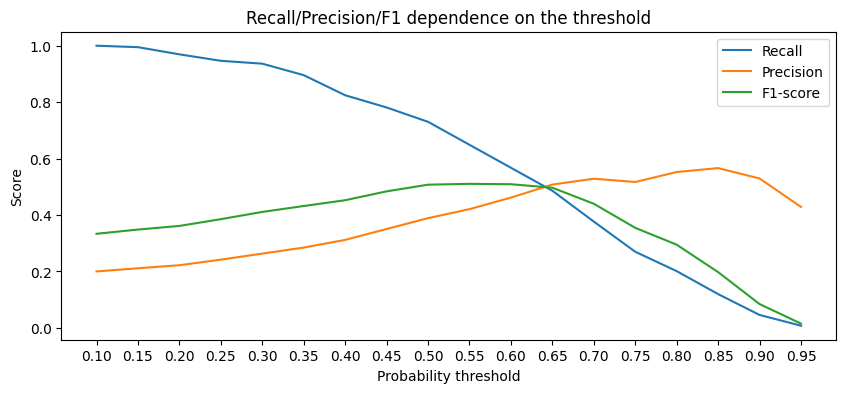

In [10]:
#Считаем вероятности наличия диабета для каждого из пациентов
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = model.predict_proba(X_test_scaled)[:, 1]
y_test_proba_pred = pd.Series(y_test_proba_pred)

recall_scores = []
precision_scores = []
f1_scores = []

#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)

#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
  #В противном случае — к классу 0
  y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
  #Считаем метрики и добавляем их в списки
  recall_scores.append(metrics.recall_score(y_test, y_test_pred))
  precision_scores.append(metrics.precision_score(y_test, y_test_pred))
  f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
ax.set_title('Recall/Precision/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(thresholds)
ax.legend();

In [11]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.6
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1607
           1       0.46      0.57      0.51       393

    accuracy                           0.79      2000
   macro avg       0.67      0.70      0.69      2000
weighted avg       0.80      0.79      0.79      2000



### Анализ результатов

После изменения порога на 0.6 результаты модели изменились:
- модель менее уверена в лояльных клиентах, но стала лучше определять тех, кто уходит.

- recall ушедших клиентов упал (с 0.73 до 0.57), но precision поднялся (с 0.39 до 0.46) - меньше ложных показателей.

- выросла точность (accuracy = 0.79) и F1-score лояльных клиентов.

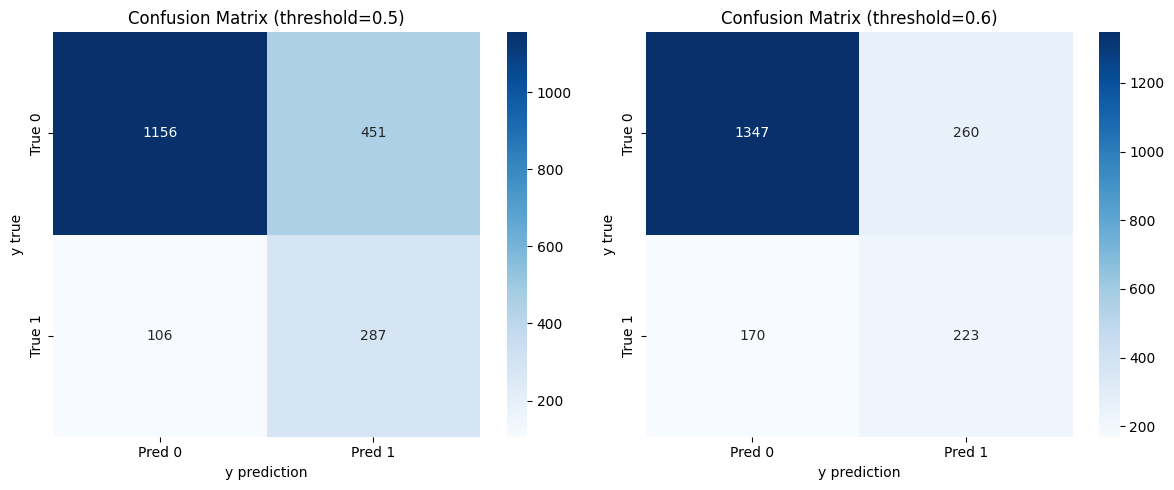

In [12]:
#Матрица ошибок
y_test_pred = (y_test_proba_pred >= 0.5)
cm = metrics.confusion_matrix(y_test, y_test_pred)

y_test_pred_opt = (y_test_proba_pred >= 0.6)
cm_opt = metrics.confusion_matrix(y_test, y_test_pred_opt)

fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
axes[0].set_title('Confusion Matrix (threshold=0.5)')
axes[0].set_xlabel('y prediction')
axes[0].set_ylabel('y true')

sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
axes[1].set_title('Confusion Matrix (threshold=0.6)')
axes[1].set_xlabel('y prediction')
axes[1].set_ylabel('y true')

plt.tight_layout()
plt.show()